In [0]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook
import seaborn as sns
import time
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

import torch

In [5]:
torch.manual_seed(0)

In [0]:
my_map = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red", "yellow", "blue"])

# Generate Dataset

In [7]:
data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


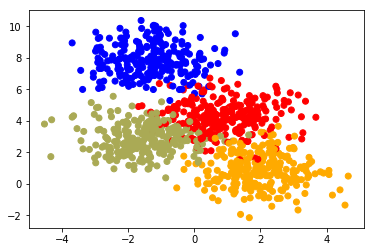

In [8]:
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=my_map)
plt.show()

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0)
print(X_train.shape, X_val.shape, labels.shape)

(750, 2) (250, 2) (1000,)


# Using Torch tensor and autograd

In [0]:
X_train, X_val, Y_train, Y_val = map(torch.tensor, (X_train, X_val, Y_train, Y_val))

In [11]:
  print(X_train.shape, Y_train.shape)

torch.Size([750, 2]) torch.Size([750])


In [0]:
def model(x):
  a1 = torch.matmul(x, weights1) + bias1  # (N, 2) * (2, 2) -> (N, 2)
  h1 = a1.sigmoid()  # (N, 2)
  a2 = torch.matmul(h1, weights2) + bias2  # (N, 2) * (2, 4) -> (N, 4)
  h2 = a2.exp() / a2.exp().sum(-1).unsqueeze(-1)
  return h2

In [13]:
a = torch.ones(3, 4)
print(a)
print(a.exp().sum(-1).unsqueeze(-1))

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
tensor([[10.8731],
        [10.8731],
        [10.8731]])


In [14]:
y_hat = torch.tensor([[0.1, 0.2, 0.3, 0.4], [0.8, 0.1, 0.05, 0.05]])
y = torch.tensor([2, 0])

(-y_hat[range(y_hat.shape[0]), y].log()).mean().item()

0.7135581970214844

In [0]:
def loss_fn(y_hat, y):
  return -(y_hat[range(y_hat.shape[0]), y].log()).mean()

In [16]:
(torch.argmax(y_hat, dim=1) == y).float().mean()

tensor(0.5000)

In [0]:
def accuracy(y_hat, y):
  pred = torch.argmax(y_hat, dim=1)
  return (pred == y).float().mean()

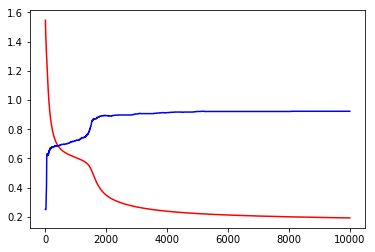

Loss before training :  1.5456441640853882
Accuracy :  0.9226666688919067


In [18]:
torch.manual_seed(0)
weights1 = torch.randn(2, 2) / math.sqrt(2)
weights1.requires_grad_()
bias1 = torch.zeros(2, requires_grad=True)

weights2 = torch.randn(2, 4) / math.sqrt(2)
weights2.requires_grad_()
bias2 = torch.zeros(4, requires_grad=True)

learning_rate = 0.2
epochs = 10000

X_train = X_train.float()
Y_train = Y_train.long()

loss_arr = []
acc_arr = []

for epoch in range(epochs):
  y_hat = model(X_train)
  loss = loss_fn(y_hat, Y_train)
  loss.backward()
  loss_arr.append(loss.item())
  acc_arr.append(accuracy(y_hat, Y_train))
  
  with torch.no_grad():
    weights1 -= weights1.grad * learning_rate
    bias1 -= bias1.grad * learning_rate
    weights2 -= weights2.grad * learning_rate
    bias2 -= bias2.grad * learning_rate
    
    weights1.grad.zero_()
    bias1.grad.zero_()
    weights2.grad.zero_()
    bias2.grad.zero_()
    
plt.plot(loss_arr, 'r-')
plt.plot(acc_arr, 'b-')
plt.show()
print("Loss before training : ", loss_arr[0])
print("Accuracy : ", acc_arr[-1].item())

# Using NN. Functional

In [0]:
import torch.nn.functional as F

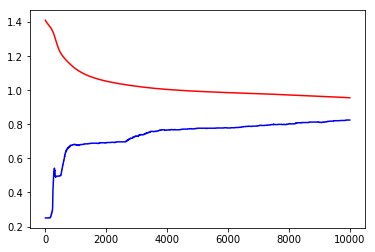

Loss before training :  1.4111980199813843
Accuracy :  0.8253333568572998


In [20]:
torch.manual_seed(0)
weights1 = torch.randn(2, 2) / math.sqrt(2)
weights1.requires_grad_()
bias1 = torch.zeros(2, requires_grad=True)

weights2 = torch.randn(2, 4) / math.sqrt(2)
weights2.requires_grad_()
bias2 = torch.zeros(4, requires_grad=True)

learning_rate = 0.2
epochs = 10000

X_train = X_train.float()
Y_train = Y_train.long()

loss_arr = []
acc_arr = []

for epoch in range(epochs):
  y_hat = model(X_train)
  loss = F.cross_entropy(y_hat, Y_train)
  loss.backward()
  loss_arr.append(loss.item())
  acc_arr.append(accuracy(y_hat, Y_train))
  
  with torch.no_grad():
    weights1 -= weights1.grad * learning_rate
    bias1 -= bias1.grad * learning_rate
    weights2 -= weights2.grad * learning_rate
    bias2 -= bias2.grad * learning_rate
    
    weights1.grad.zero_()
    bias1.grad.zero_()
    weights2.grad.zero_()
    bias2.grad.zero_()
    
plt.plot(loss_arr, 'r-')
plt.plot(acc_arr, 'b-')
plt.show()
print("Loss before training : ", loss_arr[0])
print("Accuracy : ", acc_arr[-1].item())

# Using NN. Parameter

In [0]:
import torch.nn as nn

In [0]:
class FirstNetwork(nn.Module):
  
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.weights1 = nn.Parameter(torch.randn(2, 2) / math.sqrt(2))
    self.bias1 = nn.Parameter(torch.zeros(2))
    self.weights2 = nn.Parameter(torch.randn(2, 4) / math.sqrt(2))
    self.bias2 = nn.Parameter(torch.zeros(4))
    
  def forward(self, X):
    a1 = torch.matmul(X, self.weights1) + self.bias1  # (N, 2) * (2, 2) -> (N, 2)
    h1 = a1.sigmoid()  # (N, 2)
    a2 = torch.matmul(h1, self.weights2) + self.bias2  # (N, 2) * (2, 4) -> (N, 4)
    h2 = a2.exp() / a2.exp().sum(-1).unsqueeze(-1)
    return h2

In [0]:
def fit(epochs = 10000, learning_rate = 1):
  loss_arr = []
  acc_arr = []

  for epoch in range(epochs):
    y_hat = fn(X_train)
    loss = F.cross_entropy(y_hat, Y_train)
    loss_arr.append(loss.item())
    acc_arr.append(accuracy(y_hat, Y_train))
    
    loss.backward()
    with torch.no_grad():
      for param in fn.parameters():
        param -= learning_rate * param.grad
      fn.zero_grad()
    
  plt.plot(loss_arr, 'r-')
  plt.plot(acc_arr, 'b-')
  plt.show()
  print("Loss before training : ", loss_arr[0])
  print("Accuracy : ", acc_arr[-1].item())

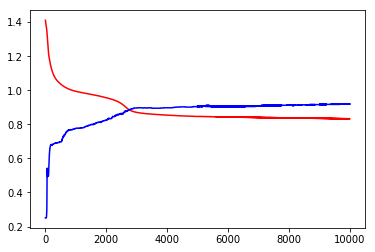

Loss before training :  1.4111980199813843
Accuracy :  0.918666660785675


In [24]:
fn = FirstNetwork()
fit()

# Using NN.Linear and Optim

In [0]:
class FirstNetwork_v1(nn.Module):
  
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.lin1 = nn.Linear(2, 2)
    self.lin2 = nn.Linear(2, 4)
    
    
  def forward(self, X):
    a1 = self.lin1(X)  # (N, 2) * (2, 2) -> (N, 2)
    h1 = a1.sigmoid()  # (N, 2)
    a2 = self.lin2(h1)  # (N, 2) * (2, 4) -> (N, 4)
    h2 = a2.exp() / a2.exp().sum(-1).unsqueeze(-1)
    return h2

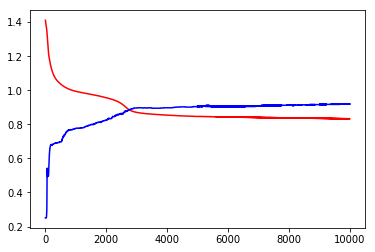

Loss before training :  1.4111980199813843
Accuracy :  0.918666660785675


In [26]:
fn = FirstNetwork()
fit()

In [0]:
from torch import optim

In [0]:
def fit_v1(epochs = 10000, learning_rate = 1):
  loss_arr = []
  acc_arr = []
  opt = optim.SGD(fn.parameters(), lr = learning_rate)

  for epoch in range(epochs):
    y_hat = fn(X_train)
    loss = F.cross_entropy(y_hat, Y_train)
    loss_arr.append(loss.item())
    acc_arr.append(accuracy(y_hat, Y_train))
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    
  plt.plot(loss_arr, 'r-')
  plt.plot(acc_arr, 'b-')
  plt.show()
  print("Loss before training : ", loss_arr[0])
  print("Loss : ", loss_arr[-1])
  print("Accuracy : ", acc_arr[-1].item())

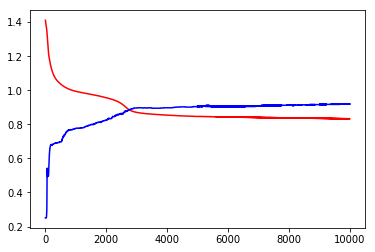

Loss before training :  1.4111980199813843
Loss :  0.833207905292511
Accuracy :  0.918666660785675


In [29]:
fn = FirstNetwork()
fit_v1()

# Using NN.Sequential

In [0]:
class FirstNetwork_v2(nn.Module):
  
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.net = nn.Sequential(
               nn.Linear(2, 2),
               nn.Sigmoid(),
               nn.Linear(2, 4),
               nn.Softmax()
            )
    
  def forward(self, X):
    return self.net(X)

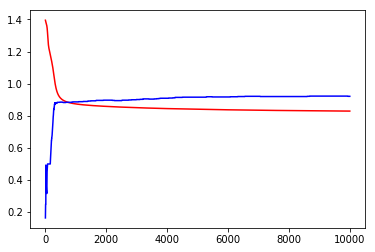

Loss before training :  1.395160436630249
Loss :  0.829351007938385
Accuracy :  0.9213333129882812


In [31]:
fn = FirstNetwork_v2()
fit_v1()

In [0]:
def fit_v2(x, y, model, opt, loss_fn, epochs=1000):
  
  for epoch in range(epochs):
    loss = loss_fn(model(x), y)
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    
  return loss.item()

In [33]:
fn = FirstNetwork_v2()
loss_fn = F.cross_entropy
opt = optim.SGD(fn.parameters(), lr=1)
fit_v2(X_train, Y_train, fn, opt, loss_fn)

0.8738410472869873

# Running it on GPU

In [34]:
device = torch.device("cpu")

X_train = X_train.to(device)
Y_train = Y_train.to(device)

fn = FirstNetwork_v2()
fn.to(device)

tic = time.time()
print("Final loss : ", fit_v2(X_train, Y_train, fn, opt, loss_fn))
toc = time.time()
print("Time : ", toc-tic)

Final loss :  1.395160436630249
Time :  1.0199470520019531


In [35]:
device = torch.device("cuda")

X_train = X_train.to(device)
Y_train = Y_train.to(device)

fn = FirstNetwork_v2()
fn.to(device)

tic = time.time()
print("Final loss : ", fit_v2(X_train, Y_train, fn, opt, loss_fn))
toc = time.time()
print("Time : ", toc-tic)

Final loss :  1.395159363746643
Time :  0.7411620616912842
